# Invariant Classifier v2

## Intro
* **Date**: 10/21/2021
* **What**: After 9 months, I'm back to tame these networks.  I'm training an invariant classifier again, but this time I'm going to be a bit smarter about how I train the final WTA layer. (Namely, I'm going to train it separately from the first two layers, specifically on the last layer, see what happens).
* **Why**: Because after thinking about this for months, the current architecture seems like the staircase to heaven, and damn it, I need to prove myself wrong.
* **Hopes**: Oh, you know, just the fundamental building blocks of GAI.
* **Limitations**: I've gotten cocky, and things like to break, so we'll see what does and doesn't work.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

m_len = 60_000
m_area = 28 * 28

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr / 255.0
x_te = x_te / 255.0

In [2]:
flat_tr = x_tr.reshape(-1, m_area)
flat_te = x_te.reshape(-1, m_area)

gp_ftr = cp.asarray(flat_tr)
gp_fte = cp.asarray(flat_te)

In [3]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


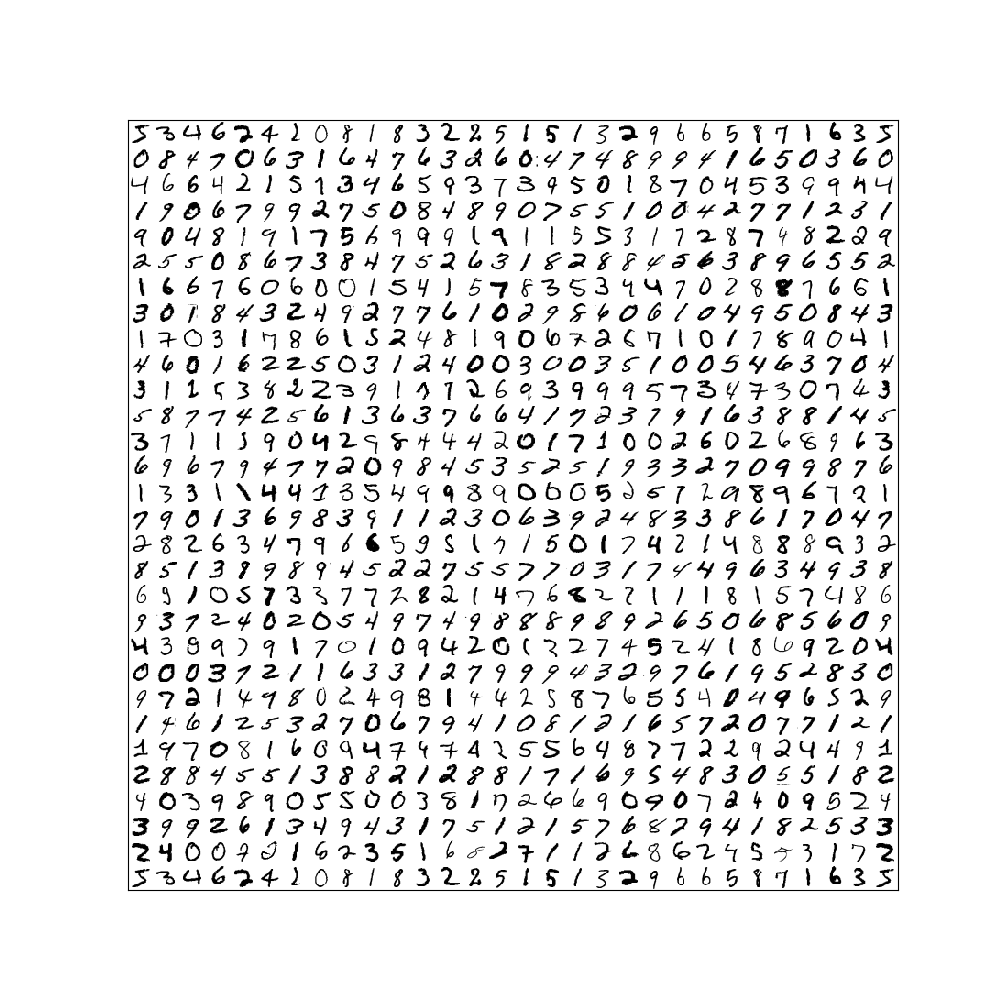

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [5]:
x_o = 420
y_o = 420

sl = 28

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

In [9]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

<IPython.core.display.Javascript object>


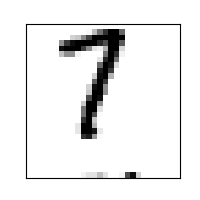

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(2, 2))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

In [8]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

# Analysis Dialogue

Here's to hoping this works.  Also, I was thinking about it, and I honestly might have _too_ much invariance to make for a good classifier.  Like basically I need to tune the number of winners higher than I would typically think.  We'll see.  That might be nothing.

<IPython.core.display.Javascript object>


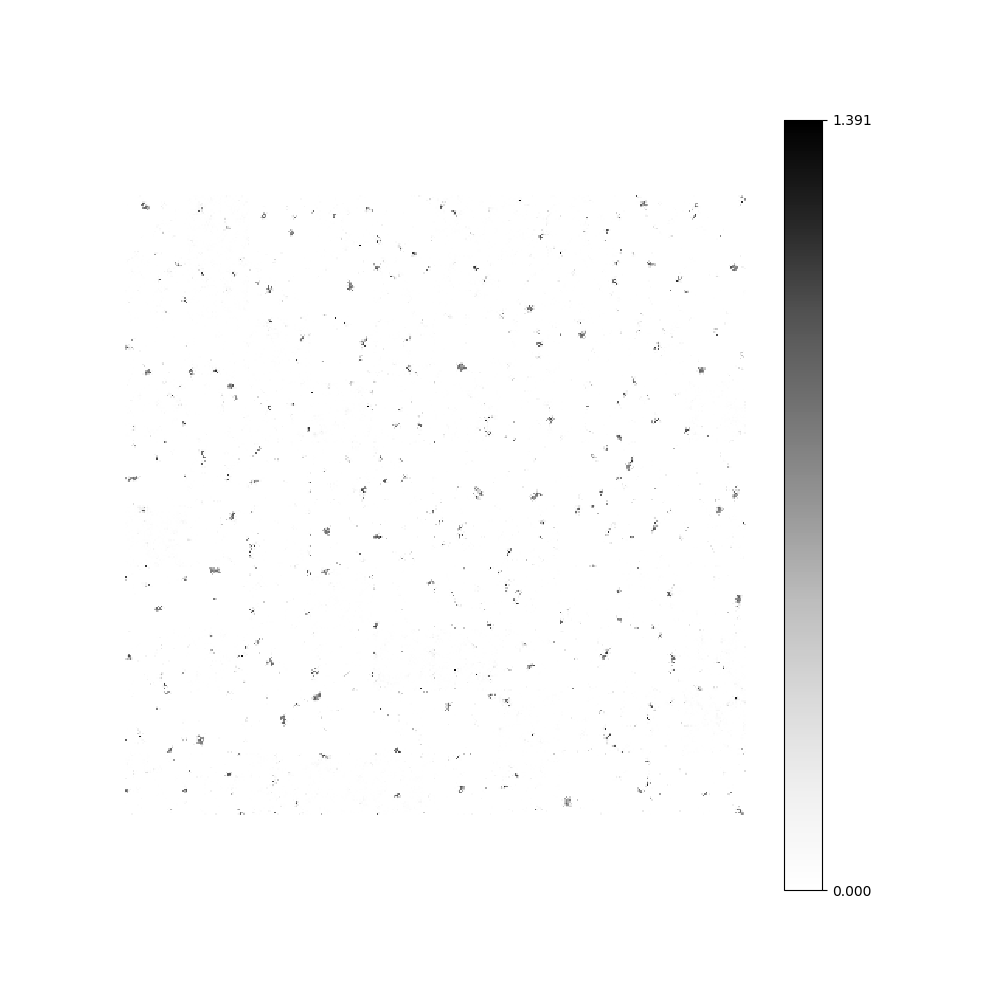

 63%|██████▎   | 6309/10000 [00:06<00:04, 912.27it/s]


KeyboardInterrupt: 

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
sex = 2
sex_coeff = 0.5

s_lat_ex = gen_lat_ex(Kx, Ky, sex, sex_coeff)

n_w = 5 #Number of winners


sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

i_lat_ex = gen_lat_ex(Ix, Iy, sex, sex_coeff)

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

i_norm = sN / iN

# WTA Layer
Wx = 10
Wy = 10
wN = Wx * Wy

ww = cp.random.uniform(0, 0.1, (wN, iN))
phi = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = s_lat_ex @ p # Lat ex
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        iv = iw @ so
        ic = i_lat_ex @ iv
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = i_norm * (iw / cp.sum(iw, axis=1).reshape(-1, 1))
            

    which_one = ep % 2
    if which_one == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)
    